### Import the necessary packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, Pipeline 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
import mlflow
from mlflow.transformers import log_model
import logging 
import torch
from torch.nn import CrossEntropyLoss
from mlflow.models.signature import infer_signature



from sklearn.model_selection import train_test_split
import pickle
import warnings
warnings.filterwarnings('ignore') 
from mlflow.sklearn import save_model 
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # This tells Hugging Face: “Don’t use parallel tokenization — avoid possible deadlocks.”

import seaborn as sns
import matplotlib.pyplot as plt

import config 


# tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
# model = AutoModelForMaskedLM.from_pretrained("distilbert/distilbert-base-uncased")

/Users/alicepope/Capstone project/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_NAME = "distilbert-base-uncased" # pulls the general-purpose DistilBERT model
DATA_PATH = "../data/data_small.csv"
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [3]:
# Load and preprocess data
logger.info("Loading and preprocessing data...")
df = pd.read_csv(DATA_PATH)

# # use only 10 rows to test end-to-end run (comment this line out later)
# df = df.sample(10, random_state=42).reset_index(drop=True)

le = LabelEncoder()
df["label"] = le.fit_transform(df["logical_fallacies"])
dataset = Dataset.from_pandas(df[["text", "label"]])
dataset = dataset.train_test_split(test_size=0.3)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

dataset = dataset.map(tokenize, batched=True)

2025-04-03 17:13:40,256: Loading and preprocessing data...
Map: 100%|██████████| 1500/1500 [00:00<00:00, 3384.07 examples/s]


In [4]:
# Initialize model, we should use AutoModelForSequenceClassification and not AutoModelForMaskedLM because we are doing classification
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(le.classes_))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Get labels from training set
y_train = dataset["train"]["label"]
# all_labels = list(range(len(le.classes_))) 
present_labels = np.unique(y_train)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=present_labels, y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [ ]:

# # Get full list of label indices
# full_class_indices = np.arange(len(le.classes_))  # e.g., [0, 1, 2, 3, 4, 5]

# # Get only the classes that appear in y_train
# y_train = dataset["train"]["label"]
# present_classes = np.unique(y_train)

# # Compute weights ONLY for the present ones
# present_weights = compute_class_weight(
#     class_weight="balanced",
#     classes=present_classes,
#     y=y_train
# )

# # Initialize full weight vector with 0s, then insert the computed ones
# full_weights = np.zeros(len(full_class_indices), dtype=np.float32)
# for idx, cls in enumerate(present_classes):
#     full_weights[cls] = present_weights[idx]

# # Convert to tensor
# class_weights_tensor = torch.tensor(full_weights, dtype=torch.float)


In [6]:
# Hugging Face’s Trainer does not support class weights out-of-the-box, so we must override the loss

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # **kwargs captures unexpected/optional arguments (like num_items_in_batch) without breaking your function
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor.to(model.device))
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [7]:
# Define metric logging function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="macro")
    recall = recall_score(labels, preds, average="macro")
    f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [8]:
# TrainingArguments This config tells the Trainer: 
# “Train for 3 epochs, evaluate and save the model after each one, 
# use moderate batch sizes, 
# and keep logs and checkpoints local — don’t auto-report to external dashboards.” --> can it be set to report to MLFlow?

args = TrainingArguments(
    output_dir="fallacy-model",
    learning_rate=3e-5, # added for fine-tuning, 5e-5 by default
    weight_decay=0.01,  # added for fine-tuning, 0 by default
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=4,  # increased from 3 for fine-tuning
    logging_dir="./logs",
    save_strategy="epoch",
    report_to="none"
)

In [9]:
# Train using Trainer and log to MLflow
# setting the MLFlow connection and experiment

from transformers import pipeline
from mlflow.models.signature import infer_signature


# Define training params to log
params = {
      "learning_rate": 3e-5,
      "weight_decay": 0.01,
      "num_train_epochs": 4,
      "evaluation_strategy": "epoch",
  }


# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


with mlflow.start_run():
    run = mlflow.active_run()
    print("Active run_id: {}".format(run.info.run_id))

    mlflow.set_tag("model_name", MODEL_NAME)
    mlflow.log_params(params)

    trainer = WeightedTrainer(
        model=model,
        args=args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    trainer.evaluate()

     # Use a properly named pipeline object (so that I don'r overwrite the original pipeline)
    clf_pipeline = pipeline("text-classification", model=trainer.model, tokenizer=tokenizer)

    # Input format for logging
    example_input = [{"text": dataset["test"][0]["text"]}]
    sample_output = clf_pipeline(example_input)
    signature = infer_signature(example_input, sample_output)

    # Log model with example input + signature
    log_model(
        clf_pipeline,
        artifact_path="model",
        input_example=example_input,
        signature=signature
    )

    # Evaluate and extract predictions
    y_test_output = trainer.predict(dataset["test"])
    y_train_output = trainer.predict(dataset["train"])

    y_test_preds = y_test_output.predictions.argmax(axis=1)
    y_test_true = y_test_output.label_ids

    y_train_preds = y_train_output.predictions.argmax(axis=1)
    y_train_true = y_train_output.label_ids

    # Define and log metrics
    def log_metrics(true, pred, split):
        mlflow.log_metric(f"{split}_accuracy", accuracy_score(true, pred))
        mlflow.log_metric(f"{split}_f1", f1_score(true, pred, average="macro"))
        mlflow.log_metric(f"{split}_precision", precision_score(true, pred, average="macro"))
        mlflow.log_metric(f"{split}_recall", recall_score(true, pred, average="macro"))

    log_metrics(y_train_true, y_train_preds, "train")
    log_metrics(y_test_true, y_test_preds, "test")

# Optional: inspect the run
# mlflow.get_run(run_id=run.info.run_id)

Active run_id: 2e3ecbd87faf42819cdb77addc01fce7


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.128775,0.490000,0.504957,0.574216,0.478874
2,No log,0.956021,0.679333,0.623335,0.660985,0.632255
3,1.071200,0.926195,0.702667,0.636903,0.684273,0.655190
4,1.071200,0.963200,0.703333,0.639729,0.666736,0.650073


Device set to use cpu
Device set to use cpu


🏃 View run honorable-carp-158 at: http://127.0.0.1:5001/#/experiments/445989666823303942/runs/2e3ecbd87faf42819cdb77addc01fce7
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/445989666823303942


In [ ]:
# from sklearn.metrics import brier_score_loss
# brier_score_loss(y_true, y_prob)

                       precision    recall  f1-score   support

           ad_hominem       0.59      0.69      0.64       154
  appeal_to_authority       0.63      0.56      0.59       103
    appeal_to_emotion       0.66      0.63      0.64       226
        false_dilemma       0.58      0.73      0.64       117
faulty_generalization       0.54      0.62      0.58       173
                 none       0.83      0.76      0.80       727

             accuracy                           0.70      1500
            macro avg       0.64      0.67      0.65      1500
         weighted avg       0.71      0.70      0.71      1500

Confusion Matrix:
[[107   4  21   4  10   8]
 [  7  58   7   1   6  24]
 [ 25   7 142  18  12  22]
 [  3   1   5  85   5  18]
 [  7   1  16   1 108  40]
 [ 31  21  24  38  58 555]]


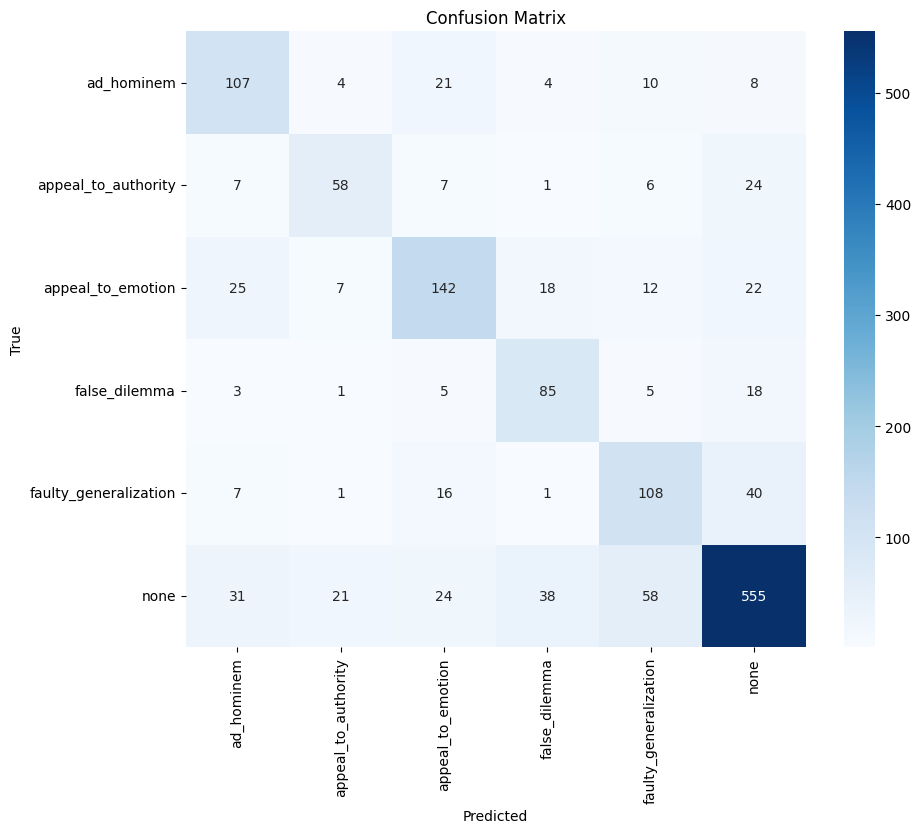

In [10]:
# Add prediction and reporting here
output = trainer.predict(dataset["test"])
predictions = np.argmax(output.predictions, axis=1)
y_true = output.label_ids

# Classification report
label_names = le.classes_
print(classification_report(y_true, predictions, target_names=label_names))

# Confusion matrix
cm = confusion_matrix(y_true, predictions)
print("Confusion Matrix:")
print(cm)

# plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



In [ ]:
path = "../models/DistilBert"
save_model(sk_model=model, path=path)

2025/04/02 17:00:46 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [ ]:
# To optimize: 

# 1. modify learning rate, epochs, and weights --> What is the default? epoch, I set to 3

# 2. Give higher weight to classes with fewer examples